## Перевірка статистичних гіпотез:
### Гіпотеза однорідності (критерій пустих блоків),
### гіпотеза незалежності (критерії Спірмена та Кендалла) та
### гіпотеза випадковості (критерій, що ґрунтується на кількості інверсій)

Всі розрахунки проводяться при рівні значимості $ \gamma = 0.05 $.

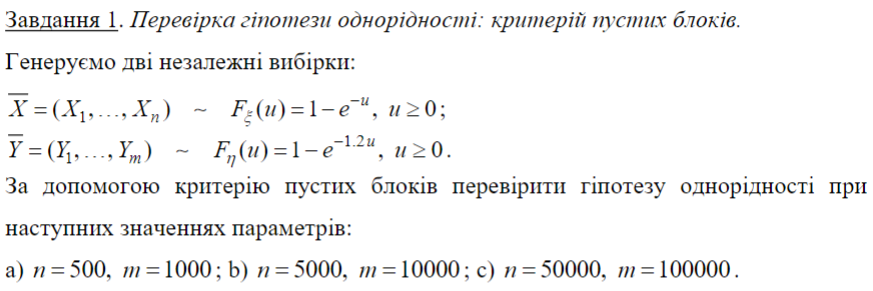

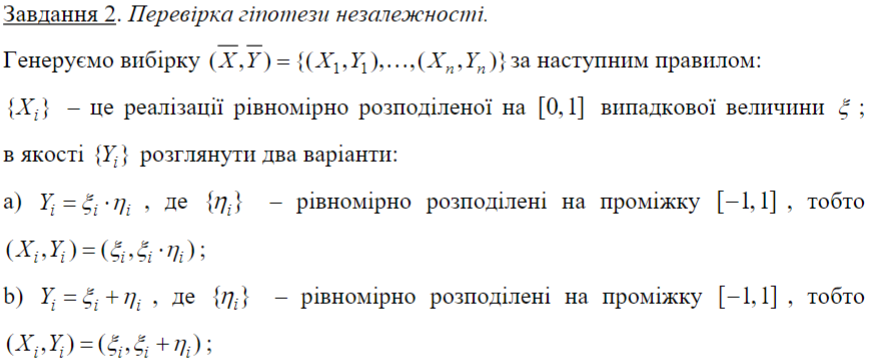

## А. Критерій Спірмена.
Перевірити гіпотезу незалежності за допомогою критерія Спірмена при наступних
значеннях параметра $n$:

а) $n = 500$ ; b) $n=5000$ ; с) $n=50000$.


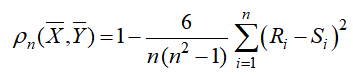

In [6]:
import numpy as np
from scipy.stats import norm

def spearman_rank_correlation(x, y):
    n = len(x)
    rank_x = np.argsort(np.argsort(x)) + 1
    rank_y = np.argsort(np.argsort(y)) + 1
    rho = 1 - (6 * np.sum((rank_x - rank_y)**2)) / (n * (n**2 - 1))
    return rho

gamma = 0.05
z_gamma = norm.ppf(1 - gamma/2)

n_values = [500, 5000, 50000]

# Варіант а) y_i = x_i * eta
print(f"{'n':^10} {'Spearman Stat':^15} {'Spearman Crit':^15} {'Spearman Conclusion':^25} {'Type':^10}")
print("=" * 75)

for n in n_values:
    xi = np.random.uniform(0, 1, n)
    eta = np.random.uniform(-1, 1, n)
    
    # ВАРІАНТ А: y_i = x_i * eta
    yi = xi * eta
    spearman_stat = spearman_rank_correlation(xi, yi)
    spearman_crit = z_gamma / np.sqrt(n - 1)
    conclusion = "Залежні" if abs(spearman_stat) > spearman_crit else "Незалежні"
    print(f"{n:^10} {abs(spearman_stat):^15.3f} {spearman_crit:^15.3f} {conclusion:^25} {'a)':^10}")

print()
for n in n_values:
    xi = np.random.uniform(0, 1, n)
    eta = np.random.uniform(-1, 1, n)

    # ВАРІАНТ Б: y_i = x_i + eta
    yi = xi + eta
    spearman_stat = spearman_rank_correlation(xi, yi)
    spearman_crit = z_gamma / np.sqrt(n - 1)
    conclusion = "Залежні" if abs(spearman_stat) > spearman_crit else "Незалежні"
    print(f"{n:^10} {abs(spearman_stat):^15.3f} {spearman_crit:^15.3f} {conclusion:^25} {'b)':^10}")
    
print("=" * 75)

    n       Spearman Stat   Spearman Crit     Spearman Conclusion       Type   
   500          0.030           0.088              Незалежні             a)    
   5000         0.011           0.028              Незалежні             a)    
  50000         0.002           0.009              Незалежні             a)    

   500          0.466           0.088               Залежні              b)    
   5000         0.430           0.028               Залежні              b)    
  50000         0.423           0.009               Залежні              b)    


## B. Критерій Кендалла.
Перевірити гіпотезу незалежності за допомогою критерія Кендалла при наступних
значеннях параметра $n$:

а) $n = 500$ ; b) $n=5000$ ; с) $n=50000$.

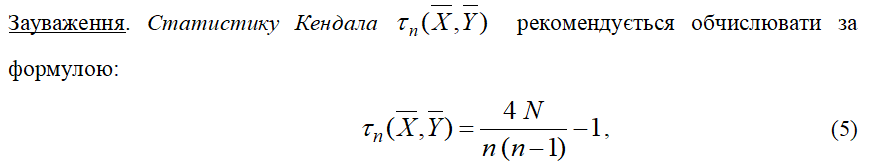

In [ ]:
def merge_count_inversions(arr):
    """
    Returns the number of inversions in 'arr' and the sorted array.
    Uses a classic merge-sort-based counting approach in O(n log n).
    """
    if len(arr) <= 1:
        return arr, 0
    
    mid = len(arr) // 2
    left, left_inv = merge_count_inversions(arr[:mid])
    right, right_inv = merge_count_inversions(arr[mid:])
    
    merged = []
    i = j = 0
    inversions = left_inv + right_inv
    while i < len(left) and j < len(right):
        if left[i] <= right[j]:
            merged.append(left[i])
            i += 1
        else:
            merged.append(right[j])
            j += 1
            inversions += (len(left) - i)
    merged.extend(left[i:])
    merged.extend(right[j:])
    return merged, inversions

def kendall_tau_optimized(x, y):
    """
    Compute Kendall's tau in O(n log n) assuming no ties.
    """
    n = len(x)
    pairs = sorted(zip(x, y), key=lambda p: p[0])
    sorted_y = [p[1] for p in pairs]
    _, inv = merge_count_inversions(sorted_y)
    total_pairs = n * (n - 1) // 2
    concordant = total_pairs - inv
    tau = (4.0 * concordant) / (n * (n - 1)) - 1
    return tau

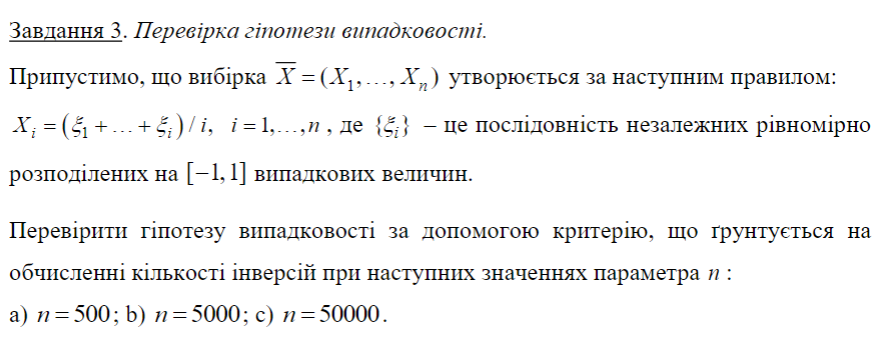